## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# 1. camera calibration -> mtx, dist pars
# 2. distorsion correction 
# 3. binarization 
# 4. perspective transform

# 5. lane pixel detection
#    5.1 lane pixel region selection
#    5.2 polyfit

# 6. fitted lines unwrap
# 7. output visual image and curvature position

##################################################################
#   1. CAMERA CALIBRATION
##################################################################
def camera_calibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    limg = lgray = None
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
            limg = img
            lgray = gray

    #We calculate the distorsion pars and matrix
    return cv2.calibrateCamera(objpoints, imgpoints, lgray.shape[::-1], None, None)

ret, mtx, dist, rvecs, tvecs = camera_calibration()

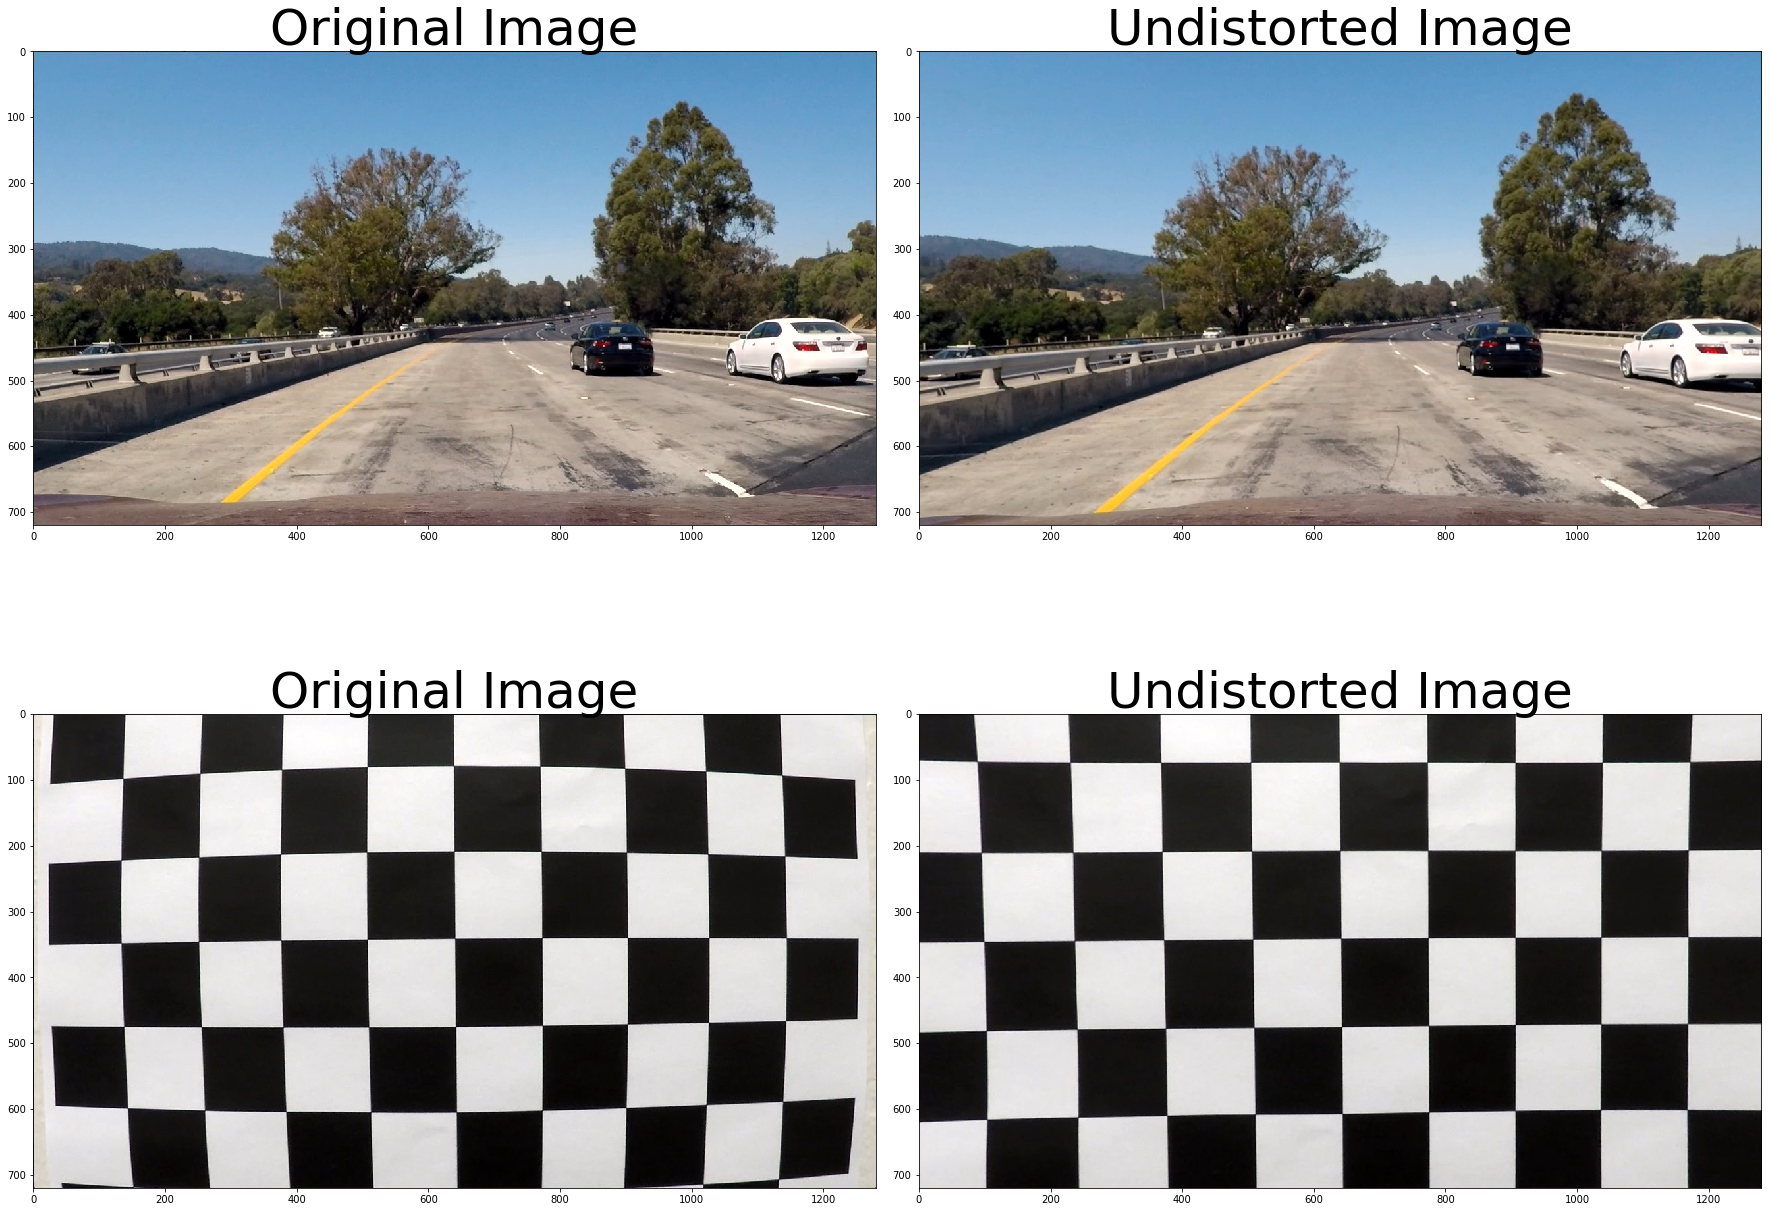

In [2]:
##################################################################
#   2. DISTORSION CORRECTION
##################################################################
#testimg = cv2.imread("./test_images/test1.jpg")  #will read in BGR mode
#testimg = cv2.cvtColor(testimg, cv2.COLOR_BGR2RGB)
calimg1 = mpimg.imread("test_images/test1.jpg")
calimg2 = mpimg.imread("camera_cal/calibration1.jpg")

def img_undistort(img, mtx, dist):
    return cv2.undistort( img, mtx, dist, None, mtx)

#test
f, ax = plt.subplots(2, 2, figsize=(24, 20))
f.tight_layout()

ax[0][0].imshow(calimg1)
ax[0][0].set_title('Original Image', fontsize=50)

undist = img_undistort( calimg1, mtx, dist )
mpimg.imsave("output_images/undistorted.png", undist)
ax[0][1].imshow( undist )
ax[0][1].set_title('Undistorted Image', fontsize=50)


ax[1][0].imshow(calimg2)
ax[1][0].set_title('Original Image', fontsize=50)

ax[1][1].imshow( img_undistort( calimg2, mtx, dist ) )
ax[1][1].set_title('Undistorted Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)






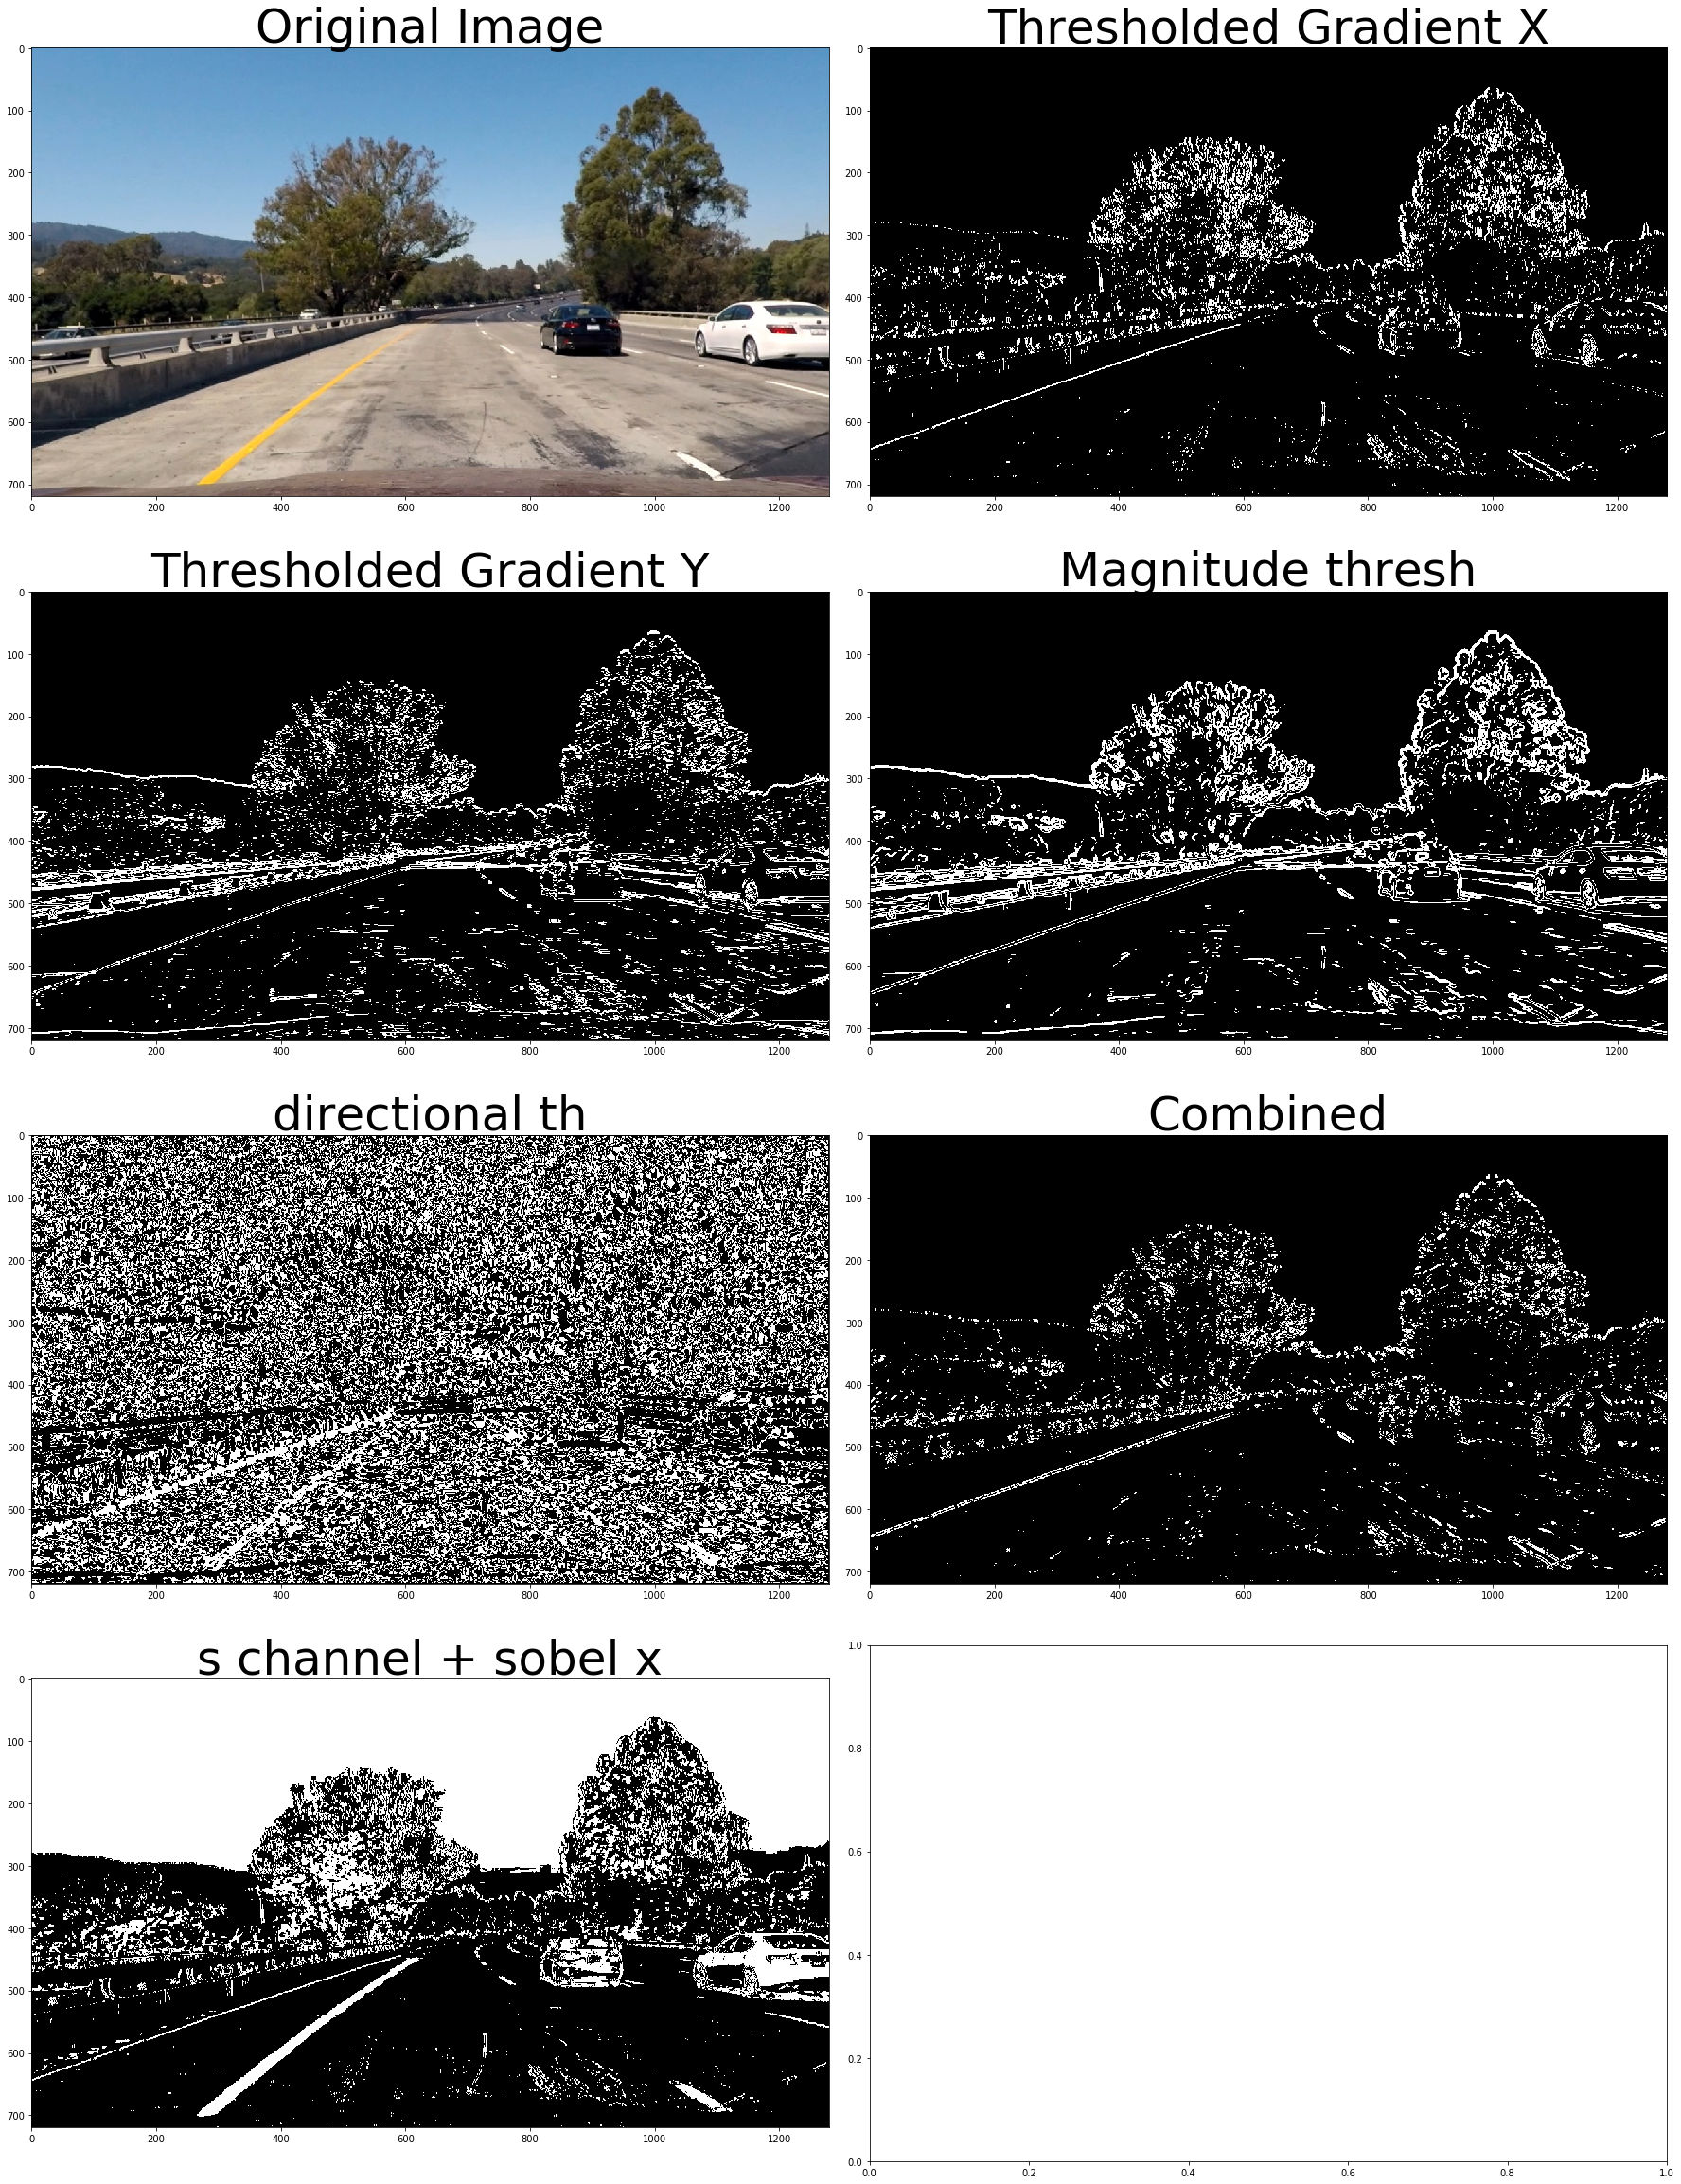

In [3]:
##################################################################
#   3. BINARIZATION 
##################################################################

# absolute sobel 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    k = [1,0] if orient=='x' else [0,1]
    sobel = cv2.Sobel(gray, cv2.CV_64F, *k, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1] )] = 1
    return sbinary

# magnitude threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    abs_sobel_scaled = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(abs_sobel_scaled)
    sbinary[ (abs_sobel_scaled >= mag_thresh[0]) & (abs_sobel_scaled <= mag_thresh[1]) ] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

#direction of threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
    # 2) x,y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dirgrad = np.arctan2( np.absolute(sobely), np.absolute(sobelx) )
    # 5) Create a binary mask where direction thresholds are met
    binary_out = np.zeros_like(dirgrad)
    binary_out[ (dirgrad>=thresh[0]) & (dirgrad<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_out

# Edit this function to create your own pipeline.
def s_and_sobelx_th(img, s_thresh=(100, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    
# Apply each of the thresholding functions
def sobel_combined(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined, gradx, grady, mag_binary, dir_binary

(combined,gradx, grady, mag_binary, dir_binary) = sobel_combined(undist)


def thresholding(img):
    return s_and_sobelx_th(img)


# Plot the result
f, axes = plt.subplots(4, 2, figsize=(24, 35))
f.tight_layout()
axes[0][0].imshow(undist)
axes[0][0].set_title('Original Image', fontsize=50)
axes[0][1].imshow(gradx, cmap='gray')
axes[0][1].set_title('Thresholded Gradient X', fontsize=50)

axes[1][0].imshow(grady, cmap='gray')
axes[1][0].set_title('Thresholded Gradient Y', fontsize=50)
axes[1][1].imshow(mag_binary, cmap='gray')
axes[1][1].set_title('Magnitude thresh', fontsize=50)

axes[2][0].imshow(dir_binary, cmap='gray')
axes[2][0].set_title('directional th', fontsize=50)
axes[2][1].imshow(combined, cmap='gray')
axes[2][1].set_title('Combined', fontsize=50)

axes[3][0].imshow(s_and_sobelx_th(undist), cmap='gray')
axes[3][0].set_title('s channel + sobel x', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

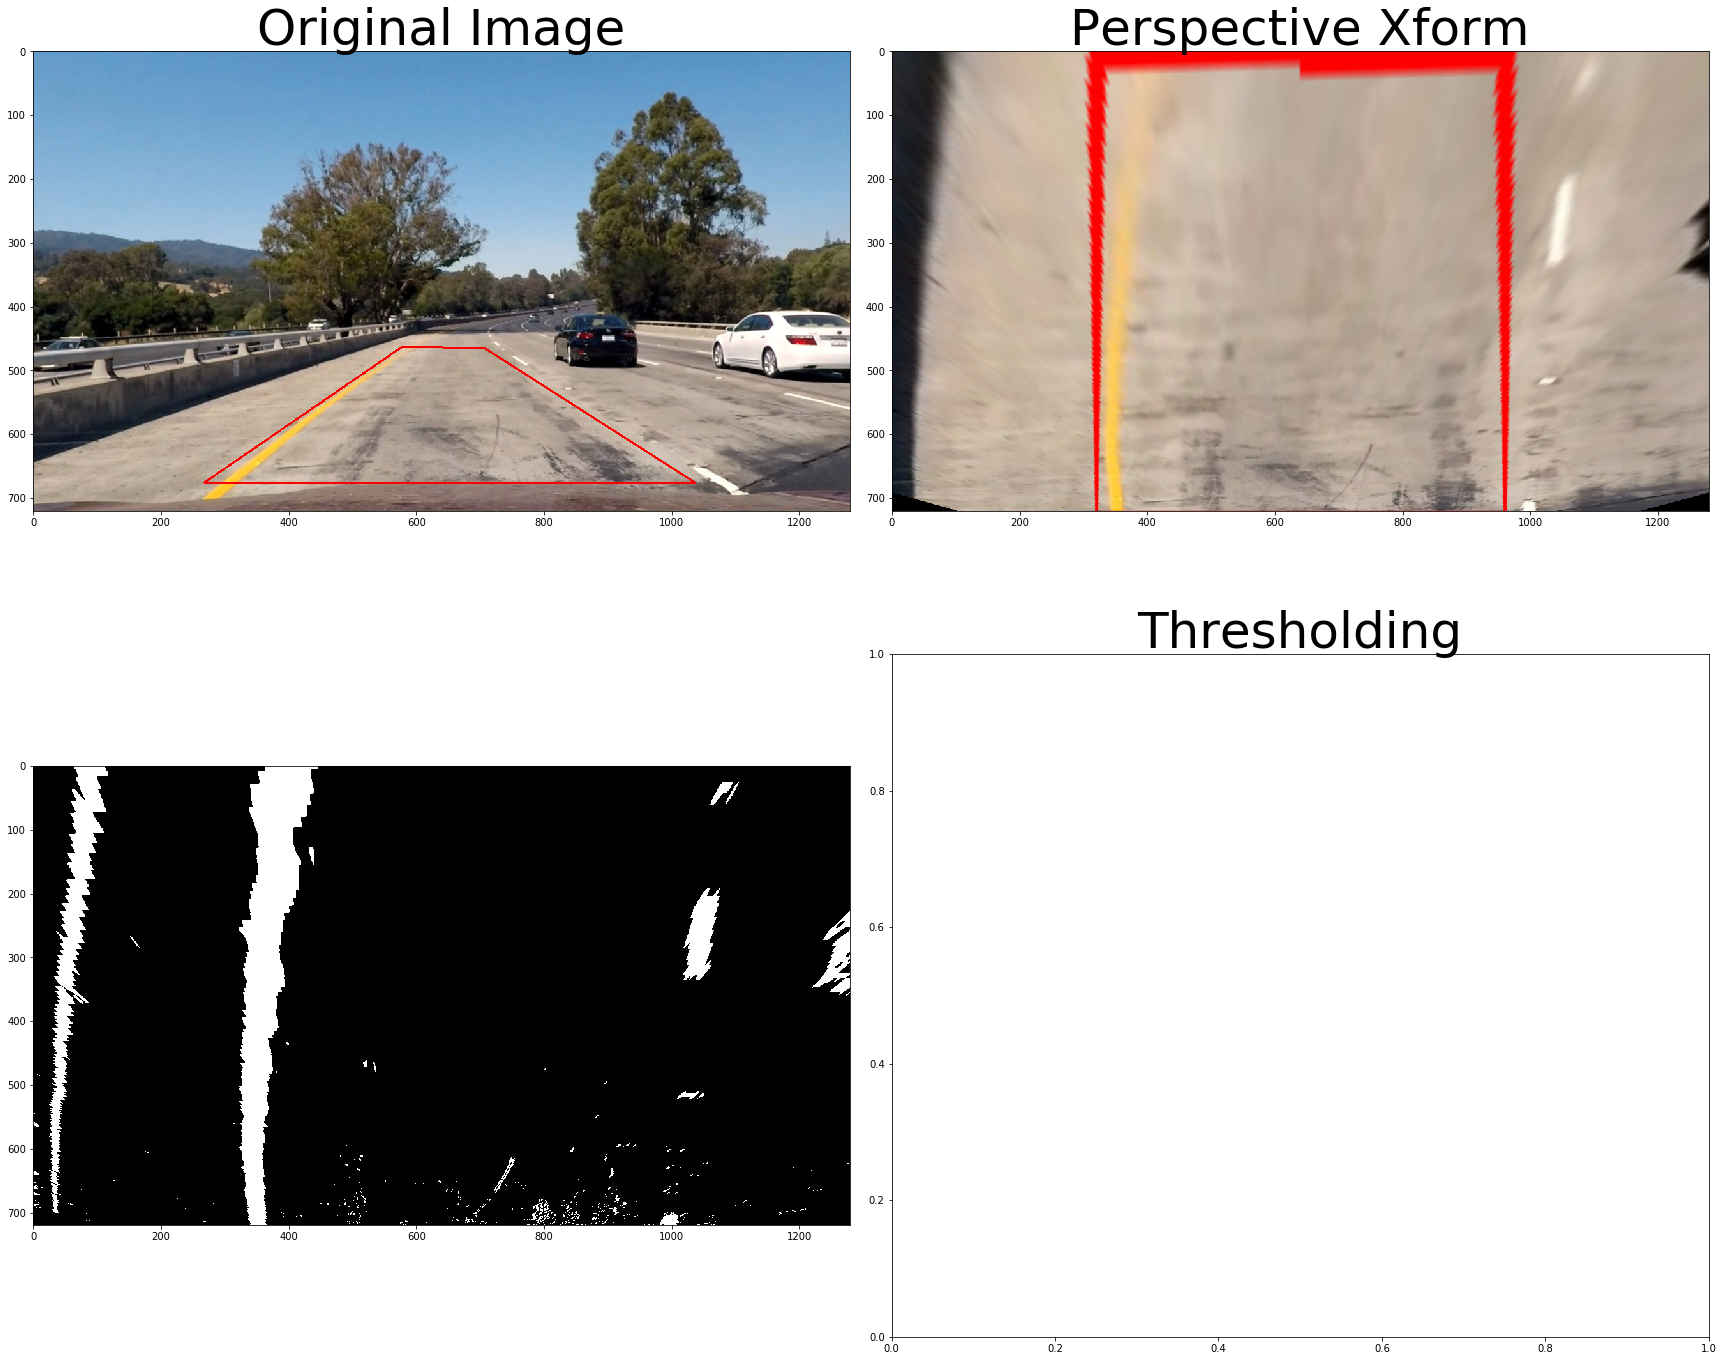

In [4]:
##################################################################
#   4. PERSPECTIVE TRANSFORM 
##################################################################

pers = undist.copy()
#mpimg.imsave("undist.png", pers)

h,w= pers.shape[0:2]

#these parameters for straight lines are from 'straight_lines.png' after applying undistortion
a,b,c,d = [[577,463],[706,464],[1037,675],[268,675]]
src = np.float32([a,b,c,d])

e,f,g,h = [[320,0], [960,0], [960,720], [320,720]]
dst = np.float32([e,f,g,h])

# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
#dst = np.float32([[d[0],0],[c[0],0],c,d])

pts = np.int32(src)
pts = pts.reshape(-1,1,2)
cv2.polylines(pers, [pts], True, (255,0,0), thickness=2)

# Given src and dst points, calculate the perspective transform matrix
M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image using OpenCV warpPerspective()
warped_w_lines = cv2.warpPerspective(pers, M, (undist.shape[1], undist.shape[0]))
warped = cv2.warpPerspective(thresholding(undist), M, (undist.shape[1], undist.shape[0]))
binary_warped = np.zeros_like(warped)
binary_warped[warped>0.5] = 1
binary_warped = binary_warped[:680,:,0]

def warp_binarize(img):
    warped = cv2.warpPerspective(thresholding(img), M, (img.shape[1], img.shape[0]))
    binary_warped = np.zeros_like(warped)
    binary_warped[warped>0.5] = 1
    return binary_warped[:,:,0]

f, axes = plt.subplots(2, 2, figsize=(24, 20))
f.tight_layout()
axes[0][0].imshow(pers)
axes[0][0].set_title('Original Image', fontsize=50)
axes[0][1].imshow(warped_w_lines, cmap='gray')
axes[0][1].set_title('Perspective Xform', fontsize=50)

axes[1][0].imshow(warp_binarize(undist) , cmap='gray')
axes[1][1].set_title('Thresholding', fontsize=50)

In [5]:
##################################################################
#   5. LANE DETECTION 
##################################################################
from enum import Enum
import copy

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # plotted pixel values from the fit
        self.ploty = None
        self.fitx = None
        
class LineDetect():
    class State(Enum):
        UNLOCKED=0
        LOCKED=1
        ONGOING=2
        LOST=3
        
    def __init__(self):
        self.debug = True
        self.state = self.State.UNLOCKED
        self.last_detected_lines = None  #last detected line
        self.last_lines = None #last retunred line
        self.lost_count = 0
        self.lost_count_max = 5
                # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #does an exponential moving average of the line fits. returns EMAed pars
    def EMA(self, prev_lines, cur_lines):
        alpha = 0.2
        if( cur_lines==None):
            return None
        if(prev_lines==None):
            return cur_lines
        else:
            ret = copy.copy(cur_lines)
            
            ret.lline.current_fit = cur_lines.lline.current_fit * alpha + prev_lines.lline.current_fit * (1-alpha)
            ret.rline.current_fit = cur_lines.rline.current_fit * alpha + prev_lines.rline.current_fit * (1-alpha)
            ret.avgcurv = cur_lines.avgcurv*alpha + prev_lines.avgcurv*(1-alpha)
            return ret
    
    class FindLineResult():
        def __init__(self):
            self.detected = False
            self.lline = None
            self.rline = None
            self.leftcurv = 0
            self.rightcurv = 0
            self.avgcurv = 0
            self.distcenter = 0
    
    # Detects lines. Returns None if no lines detected
    def find_lines(self, binary_warped):       

        # lines selection 
        if self.state == self.State.UNLOCKED:
            ret = self.find_lines_cold(binary_warped)
            if ret.detected:
                self.lost_count = 0
                self.state = self.State.ONGOING
                self.last_detected_lines = ret
            else:
                self.lost_count += 1
                
        elif self.state == self.State.ONGOING:
            ret = self.find_lines_ongoing(binary_warped, self.last_detected_lines.lline.current_fit, self.last_detected_lines.rline.current_fit)
            if ret.detected:
                self.lost_count = 0
                self.last_detected_lines = ret
            else:
                self.lost_count += 1
                self.state = self.State.UNLOCKED
                
        else:
            raise Exception("wrong state")
        
  
        self.last_lines = self.EMA( self.last_lines,  self.last_detected_lines )
        
        return [self.lost_count< self.lost_count_max and self.last_lines, self.last_lines]


    # returns true/false to validate the lines
    def lines_validation(self, lline, rline):
        # calculate the stdev of the width of the lines. should be paralellish
        
        width = rline.fitx - lline.fitx
        
        ret = True
        
        ret = ret and  np.std(width) < 50
        
        return ret
    
    # finds lines inside an area given from a previous polynomial fit
    def find_lines_ongoing(self, binary_warped, left_fit, right_fit):
        lline, rline = Line(), Line()
        
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
                          & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                           & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        lline.allx = leftx
        lline.ally = lefty
        rline.allx = rightx
        rline.ally = righty

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        lline.ploty = ploty
        lline.fitx = left_fitx
        rline.ploty = ploty
        rline.fitx = right_fitx
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = np.uint8( out_img )
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]  
        #draw lines
        cv2.polylines( out_img, [np.int32(np.column_stack((left_fitx, ploty)))] , False, (255,255,0), thickness=4 )
        cv2.polylines( out_img, [np.int32(np.column_stack((right_fitx, ploty)))] , False, (255,255,0), thickness=4 )
        
        rline.img = out_img
        lline.img = out_img
        
        # bottom center pixel
        yb =  binary_warped.shape[0]-1
        left_centerx = left_fitx[yb]
        right_centerx = right_fitx[yb]
        centerx = (left_centerx + right_centerx) / 2
        
        center_offset = binary_warped.shape[1]/2 - centerx
        
        
        
        lline.current_fit = left_fit
        rline.current_fit = right_fit
        
        ret = LineDetect.FindLineResult()
        ret.detected = self.lines_validation(lline, rline) 
        ret.lline = lline
        ret.rline = rline
        l, r = self.calculate_curvature(left_fit, right_fit)
        ret.leftcurv = l
        ret.rightcurv = r
        ret.avgcurv = (l+r)/2
        ret.distcenter = center_offset * self.xm_per_pix
        
        return ret
        
    def find_lines_cold(self, binary_warped, plot=False):
        lline, rline = Line(), Line()
        
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = np.uint8( out_img )

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),color=(0,255,0), thickness=2 )
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                              & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                               & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        lline.allx = leftx
        lline.ally = lefty
        rline.allx = rightx
        rline.ally = righty

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        lline.ploty = ploty
        lline.fitx = left_fitx
        rline.ploty = ploty
        rline.fitx = right_fitx
        
        # bottom center pixel
        yb =  binary_warped.shape[0]-1
        left_centerx = left_fitx[yb]
        right_centerx = right_fitx[yb]
        centerx = (left_centerx + right_centerx) / 2
        
        center_offset = binary_warped.shape[1]/2 - centerx
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]  

        #draw lines
        cv2.polylines( out_img, [np.int32(np.column_stack((left_fitx, ploty)))] , False, (255,255,0), thickness=4 )
        cv2.polylines( out_img, [np.int32(np.column_stack((right_fitx, ploty)))] , False, (255,255,0), thickness=4 )

        if(plot):
            plt.figure()
            plt.imshow(out_img)
            #plt.plot(left_fitx, ploty, color='yellow')
            #plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)

   
        lline.detected = True
        lline.recent_xfitted = None
        lline.bestx = None
        lline.best_fit = None
        lline.current_fit = left_fit
        lline.radius_of_curvature = self.calculate_curvature(left_fit, right_fit)[0]
        lline.line_base_pos = 0  #distance in meters of vehicle center from the line
        lline.img = out_img


        rline.detected = True
        rline.recent_xfitted = None
        rline.bestx = None
        rline.best_fit = None
        rline.current_fit = right_fit
        rline.radius_of_curvature = self.calculate_curvature(left_fit, right_fit)[1]
        rline.line_base_pos = 0  #distance in meters of vehicle center from the line
        rline.img = out_img 
 
        ret = LineDetect.FindLineResult()
        ret.detected = self.lines_validation(lline, rline) 
        ret.lline = lline
        ret.rline = rline
        ret.leftcurv = lline.radius_of_curvature
        ret.rightcurv = rline.radius_of_curvature
        ret.avgcurv = (ret.leftcurv + ret.rightcurv)/2
        ret.distcenter = center_offset * self.xm_per_pix
        return ret
    
    #calculates curvature in meters from the warped binary polynomial fit
    def calculate_curvature(self, left_fit, right_fit):
        y_eval = 720
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        sx = xm_per_pix  
        sy = ym_per_pix 

        # see writeup for derivation of this formulas
        left_fit_cr =   [(sx*left_fit[0])/(sy**2), (sx*left_fit[1])/sy,  sx*left_fit[2]]
        right_fit_cr =  [(sx*right_fit[0])/(sy**2), (sx*right_fit[1])/sy,  sx*right_fit[2]]

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        return(left_curverad, right_curverad)
    

In [6]:
##################################################################
#   6. UNWRAP
##################################################################
def unwrap(undist, warped_shape, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_shape[0]-1, warped_shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros(warped_shape).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    
        
    # Combine the result with the original image
    result = cv2.addWeighted(np.uint8(undist), 1, newwarp, 0.3, 0)
    return result




test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


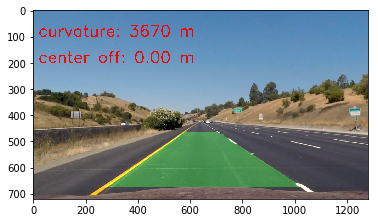

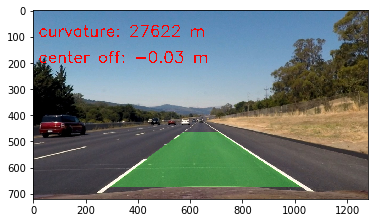

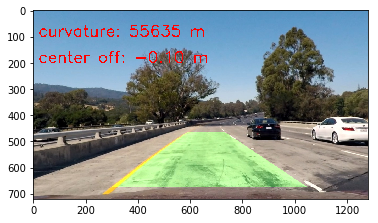

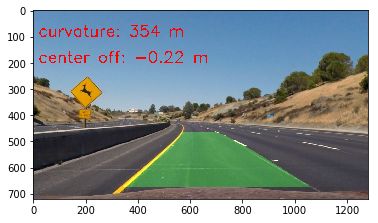

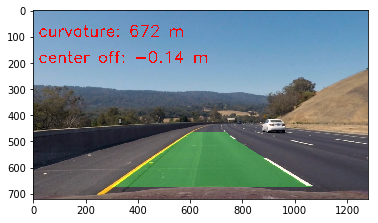

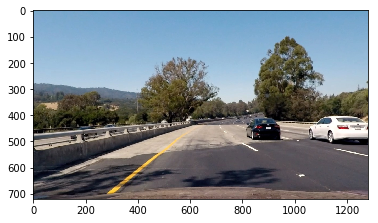

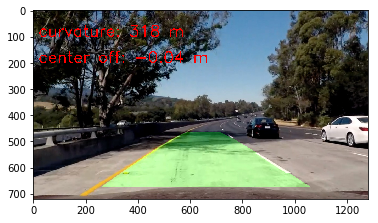

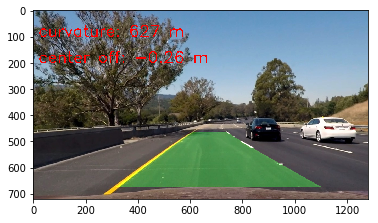

In [7]:
##################################################################
#   7. PIPELINE  
##################################################################
class Pipeline():
    def __init__(self):
        self.lline = None
        self.rline = None
        self.ldetect = LineDetect()
    
    def run(self, img, unwrapOut=False):
        #undistort
        undist = img_undistort( img, mtx, dist )
        #wark and bin
        binary_warped = warp_binarize(undist)
        #line detect
        valid, result = self.ldetect.find_lines(binary_warped)

        if(valid):
            out_img = unwrap(undist[:,:,:], binary_warped.shape[0:2], result.lline.current_fit, result.rline.current_fit) if unwrapOut else result.lline.img
            #add text stats
            cv2.putText(out_img,"curvature: {0:d} m".format(int((result.avgcurv)/2.0)), (20,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, thickness=4)
            cv2.putText(out_img,"center off: {0:.2f} m".format(result.distcenter), (20,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, thickness=4)
        else:
            out_img = undist 



        return out_img        

    
# Make a list of test images

timages = glob.glob('test_images/*.jpg')
for im in timages:
    print(im)
    p = Pipeline()    # we instanstiate a pipeline every single time to test individual images
    out = p.run(mpimg.imread(im), True)
    plt.figure()
    plt.imshow(out)
    mpimg.imsave(im+"w", out)

In [8]:
##################################################################
#   8. MOVIE CREATIONG  
##################################################################
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return p.run(image, unwrapOut=True)

p = Pipeline()
white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False).subclip(0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [05:07<00:00,  4.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min 39s, sys: 1min 19s, total: 5min 58s
Wall time: 5min 8s
